In [2]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
import importlib
import matplotlib.pyplot as plt
import os
import sys
sys.path.append("../..")
from utils import set_seed
sys.path.append("../priors")
from CheckerboardGMM import CheckerboardGMM
from SimpleSplitGMM import SimpleSplitGMM

In [4]:
# Recover datasets from files
data = np.load('balanced_double_mnist.npz')
X_train, y_train = data['X_train'], data['y_train']
X_val, y_val = data['X_val'], data['y_val']
X_test, y_test = data['X_test'], data['y_test']
print("Datasets loaded from mnist_data.npz")

set_seed(42)

X_train_tensor = torch.tensor(X_train.reshape(-1, 1, 28, 56), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val.reshape(-1, 1, 28, 56), dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test.reshape(-1, 1, 28, 56), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

print("Train set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)
print("Test set:", X_test.shape, y_test.shape)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Datasets loaded from mnist_data.npz
Seed set to: 42
Train set: (50000, 1568) (50000, 2)
Validation set: (10000, 1568) (10000, 2)
Test set: (10000, 1568) (10000, 2)


In [339]:
SCALE = 2.0
MODEL = "hybrid_v3_1x1_double"
PRIOR = "SimpleSplitGMM"
OPTIMIZER = "Adam"
TRANSFORM = 0.5
DROPOUT = 0.0
TYPE = "best_loss"

In [340]:
module = importlib.import_module(MODEL)
GeneralFlow = getattr(module, 'GeneralFlow')

if PRIOR == 'CheckerboardGMM':
    prior = CheckerboardGMM(total_dim=1568, num_classes=10, num_attr=2, device=device, scale=SCALE, fixed_means=False).to(device)
elif PRIOR == 'SimpleSplitGMM':
    prior = SimpleSplitGMM(total_dim=1568, num_classes=10, num_attr=2, device=device, scale=SCALE, fixed_means=False).to(device)
model = GeneralFlow().to(device)

checkpoint = torch.load(f"models/double/GMM/{TYPE}_{SCALE}_{MODEL}_{PRIOR}_{OPTIMIZER}_{TRANSFORM}_{DROPOUT}.pth")
model.load_state_dict(checkpoint['model_state_dict'])
prior.load_state_dict(checkpoint['prior_state_dict'])

for i in range(len(prior.means)):
    prior.means[i] = checkpoint['means'][i].to(device)

print (f"Epoch: {checkpoint['epoch']}")

import scipy.stats as stats

def estimate_accuracy(loader, n_runs=50):
    accuracies = []
    for _ in range(n_runs):
        correct = 0
        total = 0
        with torch.no_grad():
            for batch_X, batch_y in loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                # dequantize
                batch_X = (batch_X * 255.0 + torch.rand_like(batch_X)) / 256.0
                batch_X = batch_X - 0.5
                z, _ = model(batch_X)
                z_flat = z.view(z.size(0), -1)
                preds, _ = prior.classify(z_flat)
                if isinstance(preds, list):
                    preds = torch.stack(preds, dim=1)
                elif isinstance(preds, tuple): # Handling your previous logic
                    preds = torch.stack(preds[0], dim=1) if isinstance(preds[0], list) else preds[0]
                matched_rows = (preds == batch_y).all(dim=1)
                correct += matched_rows.sum().item()
                total += batch_y.size(0)
        acc = correct / total
        accuracies.append(acc)
    return np.array(accuracies)

set_seed(42)

model.eval()
prior.eval()

# Validation
val_accs = estimate_accuracy(val_loader, n_runs=10)
val_mean = val_accs.mean()
val_std = val_accs.std(ddof=1)
val_ci = stats.t.interval(0.95, len(val_accs)-1, loc=val_mean, scale=val_std/np.sqrt(len(val_accs)))
print(f"Validation accuracy: {val_mean:.4f} ± {val_ci[1]-val_mean:.4f} (95% CI)")

# Test
test_accs = estimate_accuracy(test_loader, n_runs=10)
test_mean = test_accs.mean()
test_std = test_accs.std(ddof=1)
test_ci = stats.t.interval(0.95, len(test_accs)-1, loc=test_mean, scale=test_std/np.sqrt(len(test_accs)))
print(f"Test accuracy: {test_mean:.4f} ± {test_ci[1]-test_mean:.4f} (95% CI)")

Epoch: 634
Seed set to: 42
Validation accuracy: 0.9782 ± 0.0007 (95% CI)
Test accuracy: 0.9801 ± 0.0006 (95% CI)


Temperature = 0

Seed set to: 42


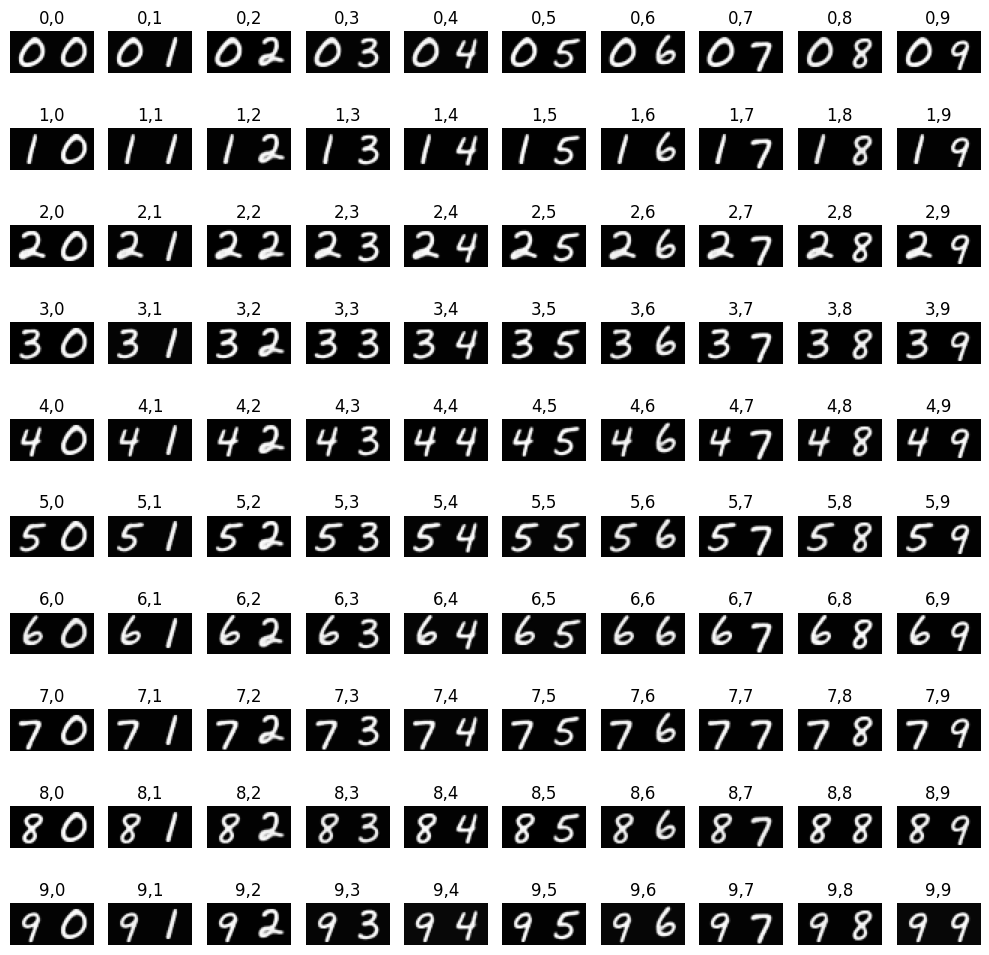

In [341]:
set_seed(42)

model.eval()

num_cat_attr0 = prior.means[0].shape[0]  # e.g., 10
num_cat_attr1 = prior.means[1].shape[0]  # e.g., 10
temp = 0

fig, axes = plt.subplots(num_cat_attr0, num_cat_attr1, figsize=(num_cat_attr1, num_cat_attr0))
with torch.no_grad():
    for i in range(num_cat_attr0):
        for j in range(num_cat_attr1):
            mean_0 = prior.means[0][i].view(-1)
            mean_1 = prior.means[1][j].view(-1)
            z = prior.get_full_latent([mean_0.unsqueeze(0), mean_1.unsqueeze(0)])
            if temp > 0:
                z = z + torch.randn_like(z) * temp

            z_structural = z.view(1, 4, 14, 28)
            img_gen = model.inverse(z_structural)

            ax = axes[i, j]
            ax.imshow(img_gen.squeeze().cpu(), cmap='gray')
            ax.set_title(f"{i},{j}")
            ax.axis('off')
plt.tight_layout()
plt.show() 

Temperature = 0.25

Seed set to: 42


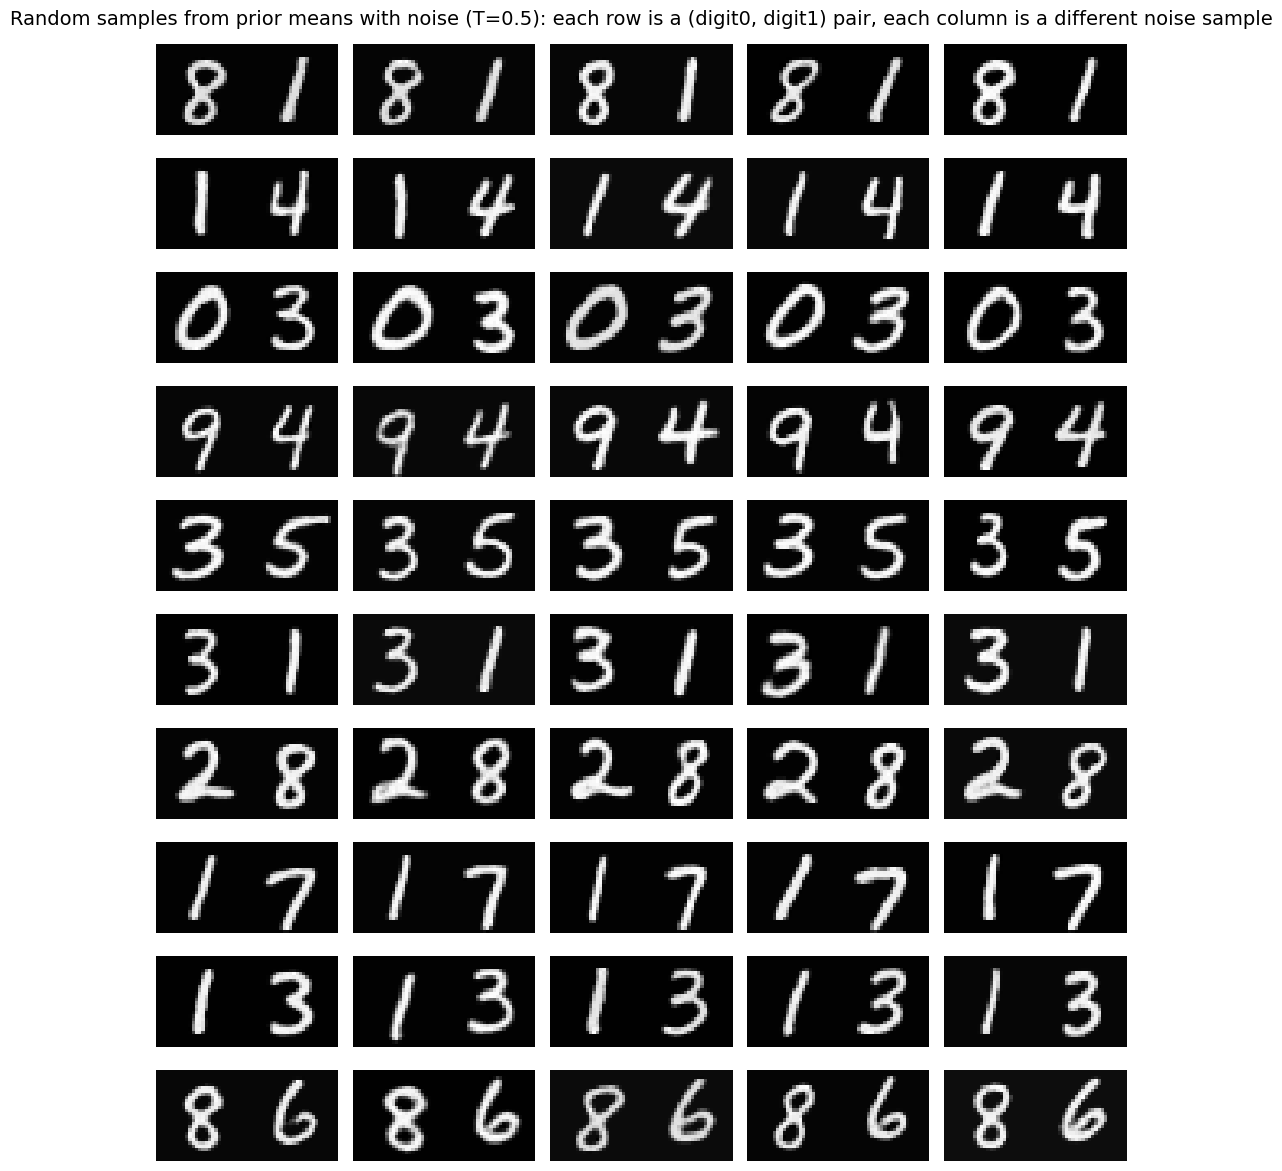

In [342]:
import random

set_seed(42)
model.eval()

num_samples = 10
num_versions = 5

temp = 0.5

# Randomly select 10 (i, j) combinations
combinations = [(i, j) for i in range(num_cat_attr0) for j in range(num_cat_attr1)]
chosen_combinations = random.sample(combinations, num_samples)

fig, axes = plt.subplots(num_samples, num_versions, figsize=(num_versions * 2, num_samples * 1.2))
fig.suptitle(f"Random samples from prior means with noise (T={temp}): each row is a (digit0, digit1) pair, each column is a different noise sample", fontsize=14)

with torch.no_grad():
    for row, (i, j) in enumerate(chosen_combinations):
        mean_0 = prior.means[0][i]
        mean_1 = prior.means[1][j]
        for col in range(num_versions):
            z = prior.get_full_latent([mean_0.unsqueeze(0), mean_1.unsqueeze(0)])
            z = z + torch.randn_like(z) * temp
            z_structural = z.view(1, 4, 14, 28)
            img_gen = model.inverse(z_structural)
            ax = axes[row, col]
            ax.imshow(img_gen.squeeze().cpu(), cmap='gray')
            if col == 0:
                ax.set_ylabel(f"{i},{j}", fontsize=10)
            ax.axis('off')
plt.tight_layout()
plt.show()

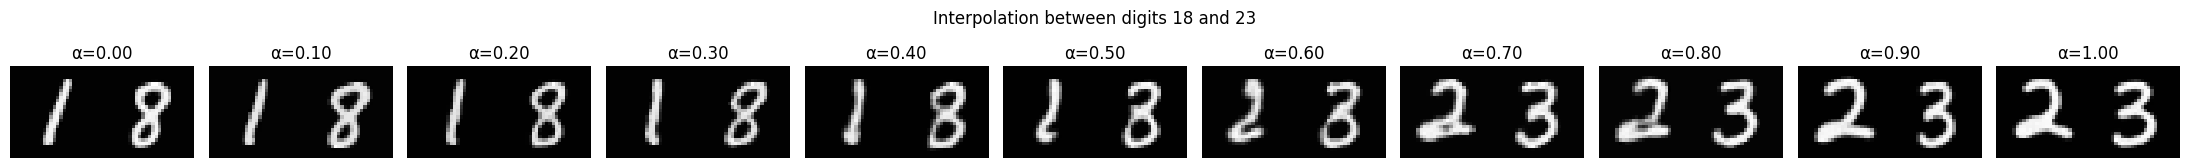

In [343]:
# Generate interpolations between 18 and 23
model.eval()
digit_a_0 = 1
digit_a_1 = 8
digit_b_0 = 2
digit_b_1 = 3
num_steps = 11
temp = 0.25
fig, axes = plt.subplots(1, num_steps, figsize=(22, 1.8))
with torch.no_grad():
    mean_a_0 = prior.means[0][digit_a_0].unsqueeze(0).to(device)
    mean_a_1 = prior.means[1][digit_a_1].unsqueeze(0).to(device)
    mean_b_0 = prior.means[0][digit_b_0].unsqueeze(0).to(device)
    mean_b_1 = prior.means[1][digit_b_1].unsqueeze(0).to(device)
    for i, alpha in enumerate(np.linspace(0, 1, num_steps)):
        z = prior.get_full_latent([(1-alpha) * mean_a_0 + alpha * mean_b_0, (1-alpha) * mean_a_1 + alpha * mean_b_1])
        z = z + torch.randn_like(z) * temp
        z_structural = z.view(1, 4, 14, 28)
        img_gen = model.inverse(z_structural)
        ax = axes[i]
        ax.imshow(img_gen.squeeze().cpu(), cmap='gray')
        ax.set_title(f"α={alpha:.2f}")
        ax.axis('off')
plt.suptitle(f"Interpolation between digits {digit_a_0}{digit_a_1} and {digit_b_0}{digit_b_1}")
plt.tight_layout()
plt.show()

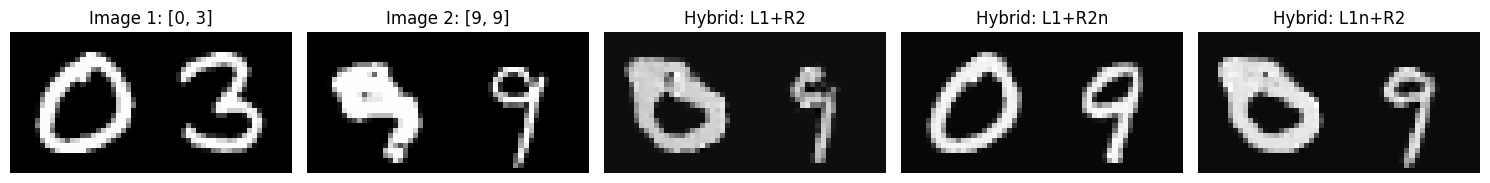

In [371]:
import random

model.eval()
idx1, idx2 = random.sample(range(len(X_test_tensor)), 2)
img1 = X_test_tensor[idx1].unsqueeze(0).to(device)
img2 = X_test_tensor[idx2].unsqueeze(0).to(device)
label1 = y_test_tensor[idx1]
label2 = y_test_tensor[idx2]

with torch.no_grad():
    img1_proc = (img1 * 255.0 + torch.rand_like(img1)) / 256.0 - 0.5
    img2_proc = (img2 * 255.0 + torch.rand_like(img2)) / 256.0 - 0.5

    z1, _ = model(img1_proc)
    z2, _ = model(img2_proc)
    z1_flat = z1.squeeze(0)
    z2_flat = z2.squeeze(0)

    mu_left_z1 = prior.means[0][label1[0]].to(device)
    mu_right_z1 = prior.means[1][label1[1]].to(device)
    mu_left_z2 = prior.means[0][label2[0]].to(device)
    mu_right_z2 = prior.means[1][label2[1]].to(device)
    difference_vector_left = z1_flat[:784] - mu_left_z1
    difference_vector_right = z1_flat[:784] - mu_right_z1

    mean_0_a = z1_flat[:784]
    mean_0_b = mu_left_z1

    mean_1_a = z2_flat[784:]
    mean_1_b = mu_right_z2
    

    z_hybrid_a = prior.get_full_latent([mean_0_a.unsqueeze(0), mean_1_a.unsqueeze(0)])
    z_hybrid_b = prior.get_full_latent([mean_0_a.unsqueeze(0), mean_1_b.unsqueeze(0)])
    z_hybrid_c = prior.get_full_latent([mean_0_b.unsqueeze(0), mean_1_a.unsqueeze(0)])

    z_hybrid_structural_a = z_hybrid_a.view(1, 4, 14, 28)
    z_hybrid_structural_b = z_hybrid_b.view(1, 4, 14, 28)
    z_hybrid_structural_c = z_hybrid_c.view(1, 4, 14, 28)

    img_hybrid_a = model.inverse(z_hybrid_structural_a)
    img_hybrid_b = model.inverse(z_hybrid_structural_b)
    img_hybrid_c = model.inverse(z_hybrid_structural_c)

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
axes[0].imshow(img1.squeeze().cpu(), cmap='gray')
axes[0].set_title(f"Image 1: {label1.tolist()}")
axes[0].axis('off')
axes[1].imshow(img2.squeeze().cpu(), cmap='gray')
axes[1].set_title(f"Image 2: {label2.tolist()}")
axes[1].axis('off')
axes[2].imshow(img_hybrid_a.squeeze().cpu(), cmap='gray')
axes[2].set_title("Hybrid: L1+R2")
axes[2].axis('off')
axes[3].imshow(img_hybrid_b.squeeze().cpu(), cmap='gray')
axes[3].set_title("Hybrid: L1+R2n")
axes[3].axis('off')
axes[4].imshow(img_hybrid_c.squeeze().cpu(), cmap='gray')
axes[4].set_title("Hybrid: L1n+R2")
axes[4].axis('off')
plt.tight_layout()
plt.show()